## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
import pathlib

from copy import deepcopy

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('dark_background')

In [4]:
from pudl_rmi.make_plant_parts_eia import *
pd.options.display.max_columns = None

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing objectDEBUG

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [7]:
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine,freq='AS',
    roll_fuel_cost=True,
    fill_fuel_cost=True,
    fill_net_gen=True
)

In [8]:
parts_compiler = CompilePlantParts(pudl_out)

In [9]:
pudl_out.mcoe()

Allocating net generation from the generation_fuel_eia923 to the generator level instead of using the less complete generation_eia923 table.
Removing 3465 generators that retired mid-year out of 373857
No records found with fuel-only records. This is expected.
Ratio calc types: 
   All gens w/in generation table:  71405#, 1.2e+07 MW
   Some gens w/in generation table: 2584#, 1.6e+05 MW
   No gens w/in generation table:   330520#, 1.5e+07 MW
   GF table records have no PM:     0#


/Users/aesharpe/Desktop/Work/Catalyst_Coop/pudl/src/pudl/analysis/allocate_net_gen.py:783: UserWarning: Ooopsies. You got 128 records where the 'frac' column isn't adding up to 1 for each 'IDX_PM_FUEL' group. Check 'make_allocation_frac()'
  warnings.warn(


1.174% of records have are partially off from their 'IDX_PM_FUEL' group
gen v fuel table net gen diff:      42.2%
new v fuel table net gen diff:      99.6%
new v fuel table fuel (mmbtu) diff: 99.5%
6.63% of generator records are more that 5% off from the net generation table
filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages


,plant_id_eia,generator_id,report_date,unit_id_pudl,plant_id_pudl,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,associated_combined_heat_power,balancing_authority_code_eia,balancing_authority_name_eia,bga_source,bypass_heat_recovery,capacity_factor,capacity_mw,carbon_capture,city,cofire_fuels,county,current_planned_operating_date,data_source,deliver_power_transgrid,distributed_generation,duct_burners,energy_source_1_transport_1,energy_source_1_transport_2,energy_source_1_transport_3,energy_source_2_transport_1,energy_source_2_transport_2,energy_source_2_transport_3,energy_source_code_1,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,fluidized_bed_tech,fuel_cost_from_eiaapi,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,fuel_type_count,grid_voltage_2_kv,grid_voltage_3_kv,grid_voltage_kv,heat_rate_mmbtu_mwh,iso_rto_code,latitude,longitude,minimum_load_mw,multiple_fuels,nameplate_power_factor,net_generation_mwh,operating_date,operating_switch,operational_status,operational_status_code,original_planned_operating_date,other_combustion_tech,other_modifications_date,other_planned_modifications,owned_by_non_utility,ownership_code,planned_derate_date,planned_energy_source_code_1,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,previously_canceled,primary_purpose_naics_id,prime_mover_code,pulverized_coal_tech,reactive_power_output_mvar,retirement_date,rto_iso_lmp_node_id,rto_iso_location_wholesale_reporting_id,sector_id,sector_name,service_area,solid_fuel_gasification,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,state,stoker_tech,street_address,subcritical_tech,summer_capacity_estimate,summer_capacity_mw,summer_estimated_capability_mw,supercritical_tech,switch_oil_gas,syncronized_transmission_grid,technology_description,time_cold_shutdown_full_load_code,timezone,topping_bottoming_code,total_fuel_cost,total_mmbtu,turbines_inverters_hydrokinetics,turbines_num,ultrasupercritical_tech,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_estimate,winter_capacity_mw,winter_estimated_capability_mw,zip_code
344844,1,1,2019-01-01,<NA>,15118,Sand Point,63560,6409,"TDX Sand Point Generating, LLC",False,NaN,<NA>,<NA>,False,0.104947,0.9,<NA>,Sand Point,<NA>,Aleutians East,NaT,eia860,<NA>,<NA>,False,NaN,NaN,NaN,NaN,NaN,NaN,DFO,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,NaN,NaN,NaN,oil,2,NaN,NaN,0.48,NaN,<NA>,55.339722,-160.497222,0.4,False,0.80,827.400000,2000-12-01,<NA>,existing,SB,NaT,<NA>,NaT,<NA>,<NA>,S,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,<NA>,22,IC,<NA>,NaN,NaT,<NA>,<NA>,2,IPP Non-CHP,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,AK,<NA>,100 Power Plant Way,<NA>,<NA>,0.4,NaN,<NA>,<NA>,False,Petroleum Liquids,10M,America/Anchorage,X,NaN,NaN,NaN,<NA>,<NA>,NaT,False,<NA>,0.4,NaN,99661
344845,1,2,2019-01-01,<NA>,15118,Sand Point,63560,6409,"TDX Sand Point Generating, LLC",False,NaN,<NA>,<NA>,False,0.104947,0.9,<NA>,Sand Point,<NA>,Aleutians East,NaT,eia860,<NA>,<NA>,False,NaN,NaN,NaN,NaN,NaN,NaN,DFO,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,<NA>,NaN,NaN,NaN,oil,2,NaN,NaN,0.48,NaN,<NA>,55.339722,-160.497222,0.3,False,0.80,827.400000,2000-12-01,<NA>,existing,OP,NaT,<NA>,NaT,<NA>,<NA>,S,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,<NA>,22,IC,<NA>,NaN,NaT,<NA>,<NA>,2,IPP Non-CHP,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,AK,<NA>,100 Power Plant Way,<NA>,<NA>,0.3,NaN,<NA>,<NA>,False,Petroleum Liquids,10M,America/Anchorage,X,NaN,NaN,NaN,<NA>,<NA>,NaT,False,<NA>,0.3,NaN,99661
344846,1,3,2019-01-01,<NA>,15118,Sand Point,63560,6409,"TDX Sand Point Generating, LLC",False,NaN,<NA>,<NA>,False,0.104947,0.5,<

In [10]:
%%time
# there is a warning in here that will scream if don't have utility ids
# for all of the generators. i've fixed this on the PUDL side by requiring
# utility id's to be present in the annual generators table
plant_parts_df = parts_compiler.generate_master_plant_parts()

Generating the mega generator table with ownership.
true grans found for plant: 126639
true grans found for plant_unit: 130536
true grans found for plant_prime_mover: 40181
true grans found for plant_technology: 15898
true grans found for plant_prime_fuel: 2875
true grans found for plant_ferc_acct: 7375
true grans found for plant_gen: 284259
begin aggregation for: plant
begin aggregation for: plant_unit
begin aggregation for: plant_prime_mover
begin aggregation for: plant_technology
begin aggregation for: plant_prime_fuel
begin aggregation for: plant_ferc_acct
begin aggregation for: plant_gen
CPU times: user 10min 28s, sys: 2min 35s, total: 13min 3s
Wall time: 16min 34s


In [11]:
parts_compiler.test_run_aggregations()

Begining tests for plant:
  Results for total_fuel_cost: [False, True]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, False]
  Results for total_mmbtu: [False, True]
Begining tests for plant_unit:
  Results for total_fuel_cost: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_prime_mover:
  Results for total_fuel_cost: [False, True]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, False]
  Results for total_mmbtu: [False, True]
Begining tests for plant_technology:
  Results for total_fuel_cost: [False, True]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, False]
  Results for total_mmbtu: [False, True]
Begining tests for plant_prime_fuel:
  Results for total_fuel_cost: [False, True]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, Fals

In [12]:
file_path_mul = pathlib.Path().cwd().parent /'outputs' /'master_unit_list.pkl.gz'
plant_parts_df_old = pd.read_pickle(file_path_mul)
len(plant_parts_df)/len(plant_parts_df_old)

1.0

In [13]:
file_path_mul = pathlib.Path().cwd().parent /'outputs' /'master_unit_list.pkl.gz'
file_path_mul_csv = pathlib.Path().cwd().parent / 'outputs'/'master_unit_list.csv.gz'
plant_parts_df.to_csv(file_path_mul_csv)
plant_parts_df.to_pickle(file_path_mul)

In [26]:
len(plant_parts_df[plant_parts_df.utility_id_pudl.isnull()])/len(plant_parts_df)

0.18701161334887537

In [14]:
compiled_plant_parts = {}
compiled_plant_parts_true = {}
true_parts_df = plant_parts_df[plant_parts_df.true_gran]
for part in PLANT_PARTS.keys():
    part_df = plant_parts_df[(plant_parts_df['plant_part'] == part)]
    compiled_plant_parts_true[part] = true_parts_df[(true_parts_df['plant_part'] == part)]
    compiled_plant_parts[part] = part_df

In [15]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    gens = compiled_plant_parts['plant_gen']
    negative_fields = gens[gens[field] < 0].plant_id_eia.unique()
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            id_cols = ['plant_id_eia', 'report_date', 'utility_id_eia', 'ownership']
            try:
                merge_df = (
                    compiled_plant_parts['plant'][id_cols + [field]]
                    .merge(
                        df[id_cols+ ['generator_id'] + [field]],
                        on=id_cols,
                        suffixes=('_plant',f'_{plant_gran}')
                        )
                    )
                # this is for the try
                if field in ['capacity_mw', 'net_generation_mwh', 'total_mmbtu']:
                    baddies = (
                        merge_df[
                            (merge_df[field_plant] < merge_df[field_gran])
                            & ~(merge_df.plant_id_eia.isin(negative_fields))
                        ]
                        .set_index(id_cols + ['generator_id'])
                        [[field_plant, field_gran]])
                    if not baddies.empty:
                        raise AssertionError(f"{plant_gran}/{field} found some baddies {len(baddies)}\n {baddies}")
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='aquamarine', alpha=0.1, label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

/var/folders/tf/l271ymp92vvbty6j01j580xm0000gn/T/ipykernel_51850/2841234712.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))


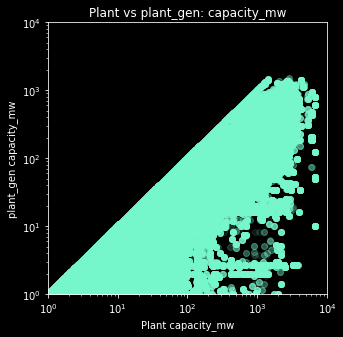

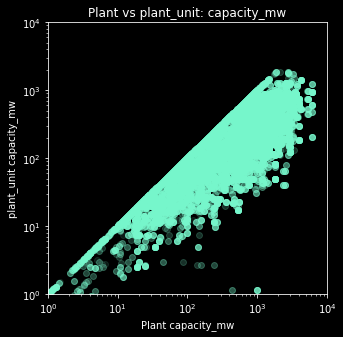

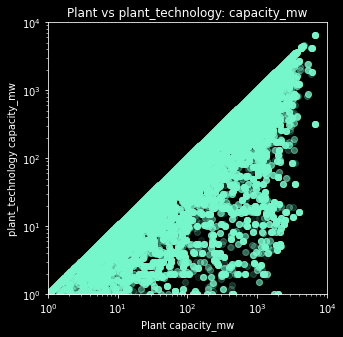

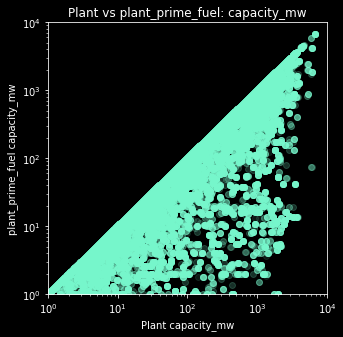

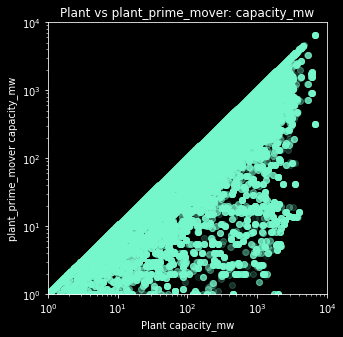

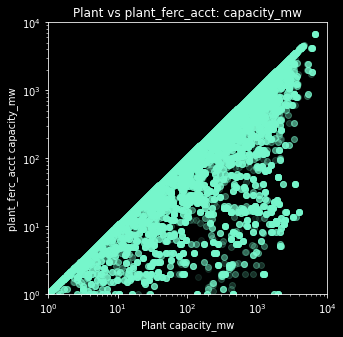

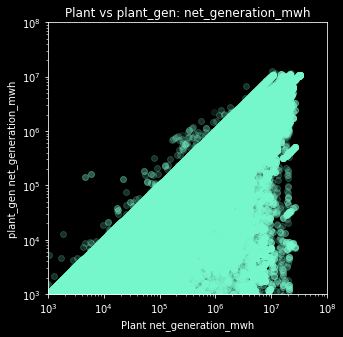

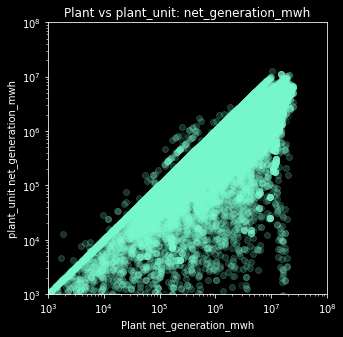

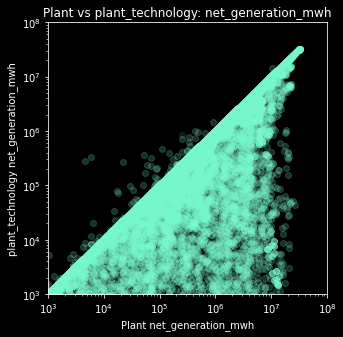

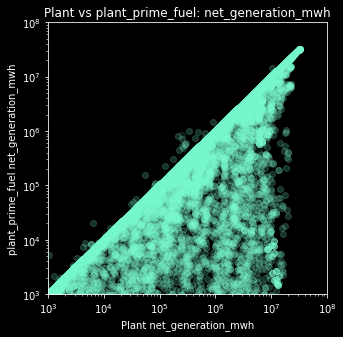

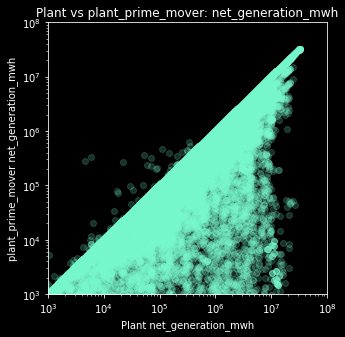

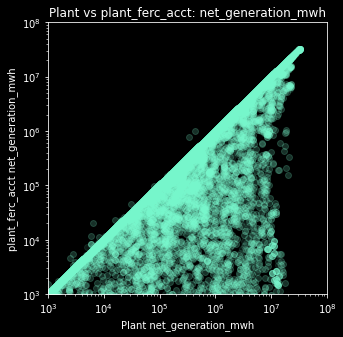

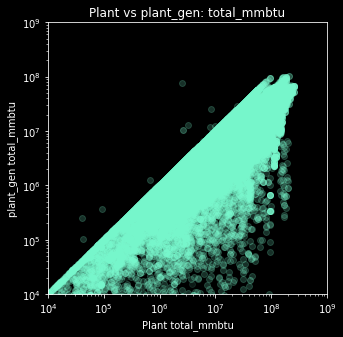

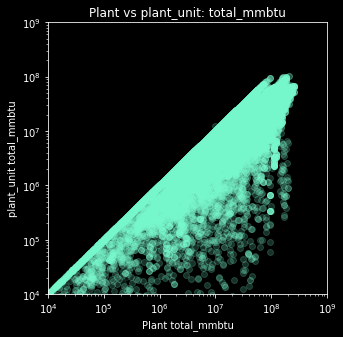

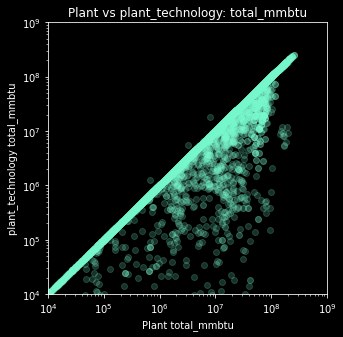

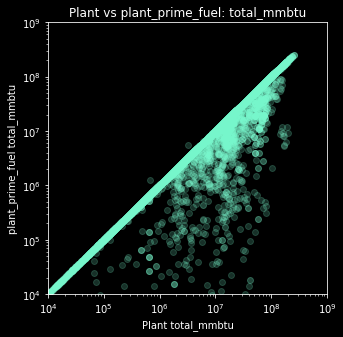

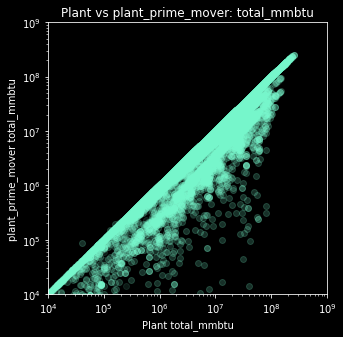

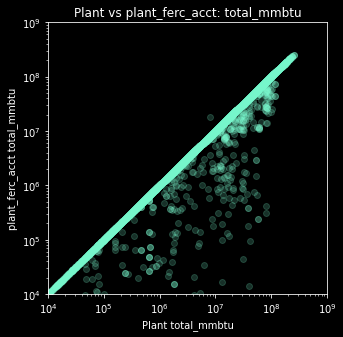

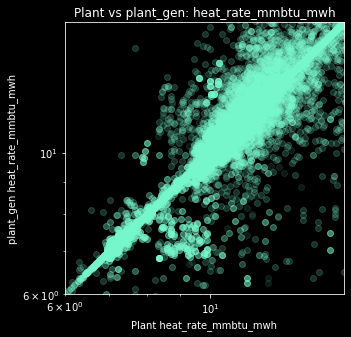

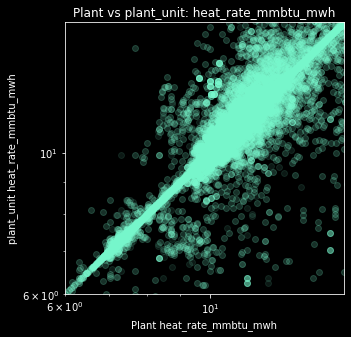

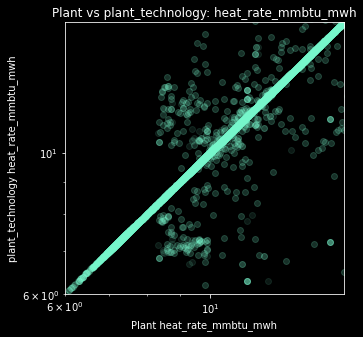

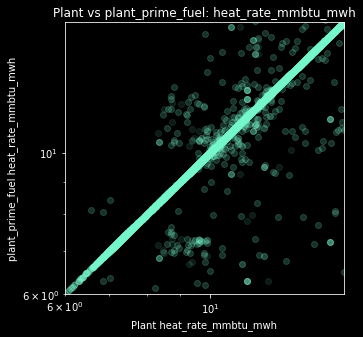

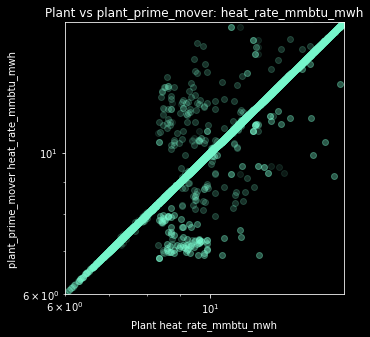

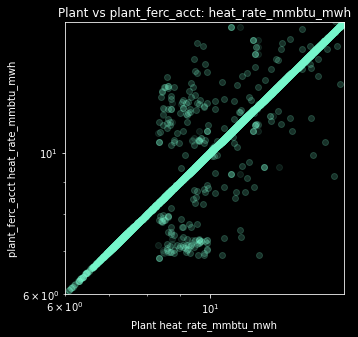

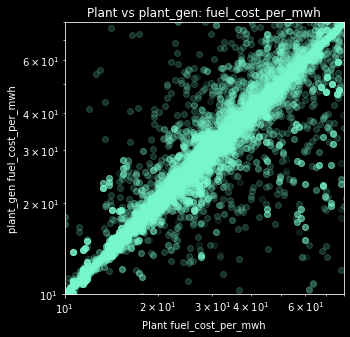

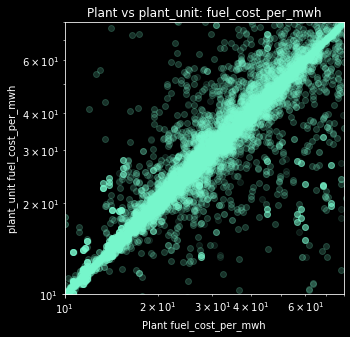

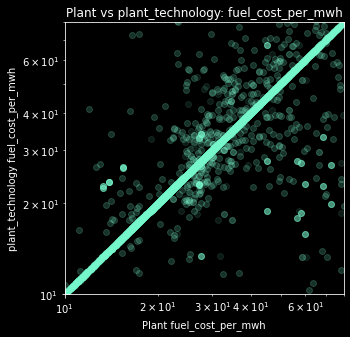

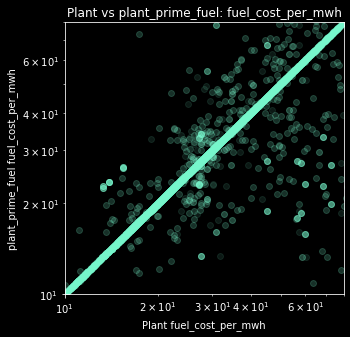

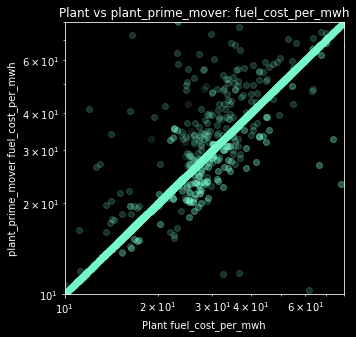

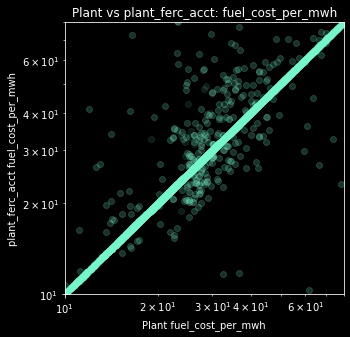

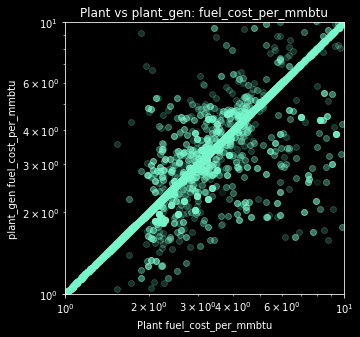

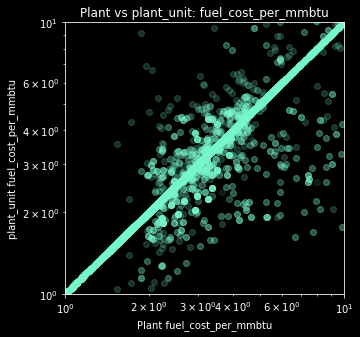

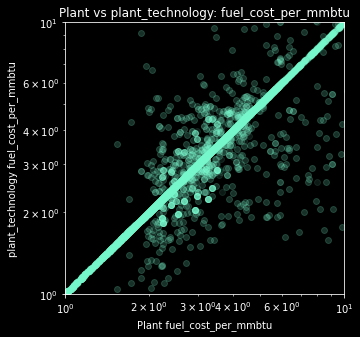

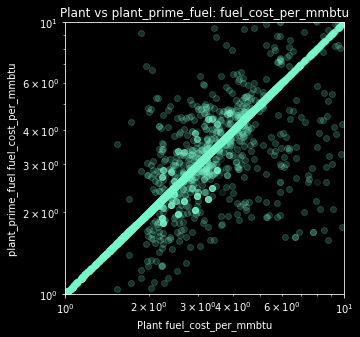

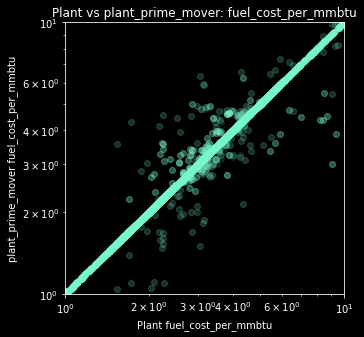

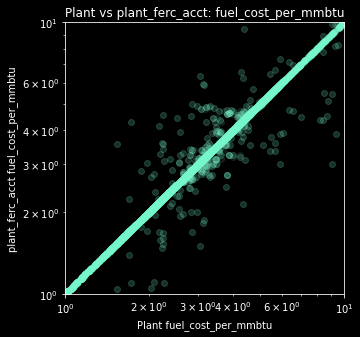

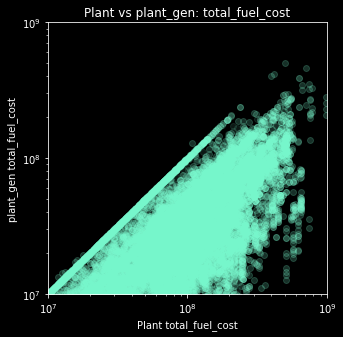

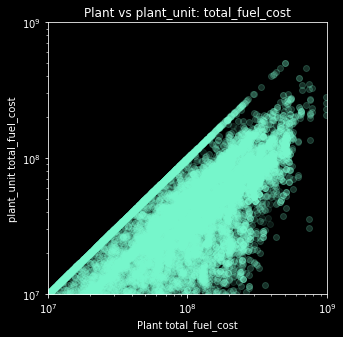

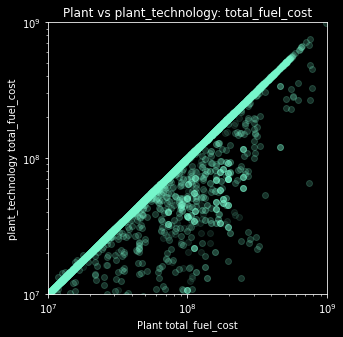

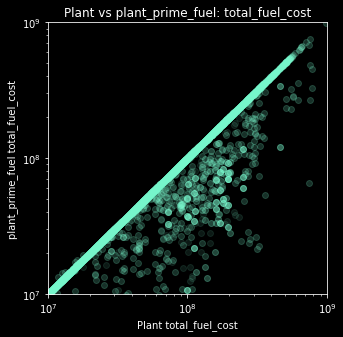

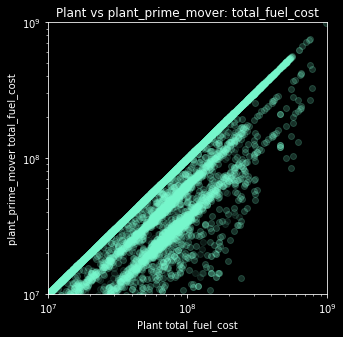

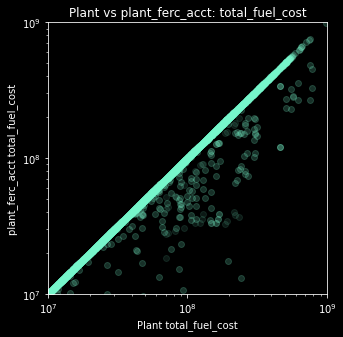

In [16]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    'net_generation_mwh',
    'total_mmbtu',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    'total_mmbtu': (1e4,1e9),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")

In [17]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="aquamarine",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [18]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,200000000)
}

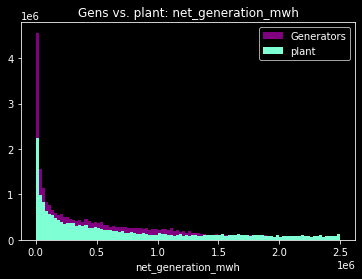

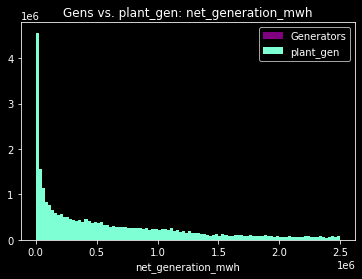

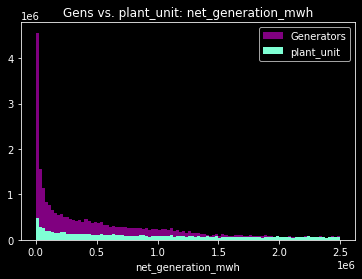

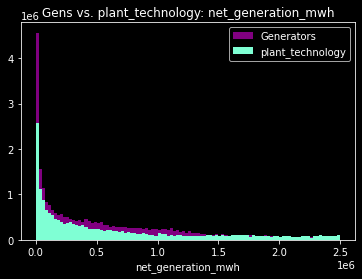

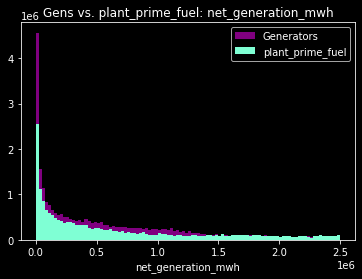

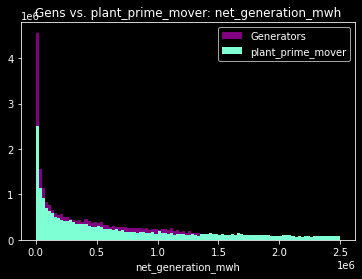

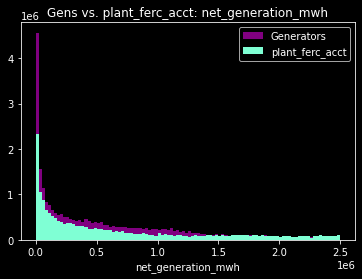

In [19]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

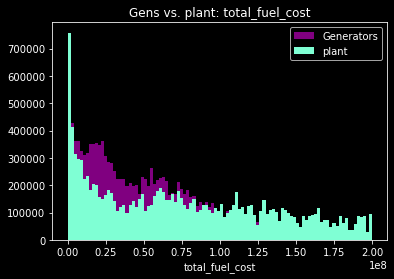

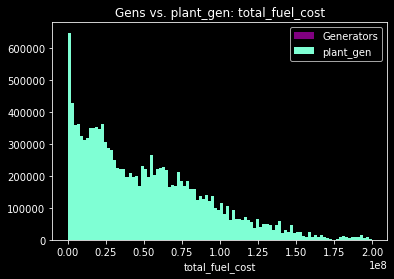

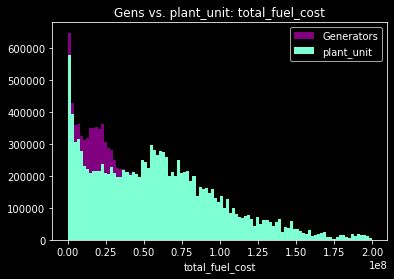

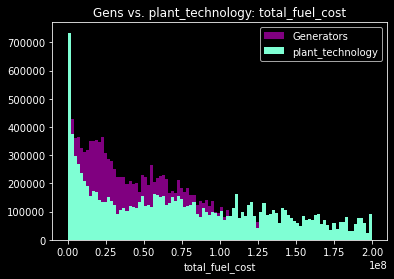

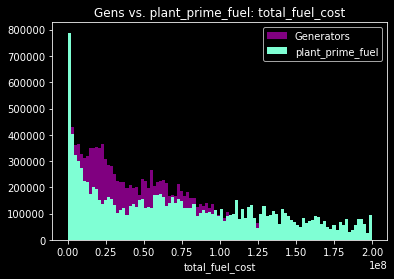

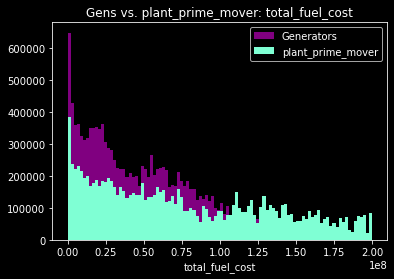

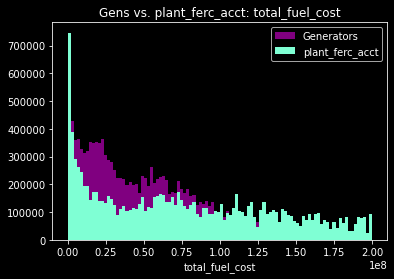

In [20]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

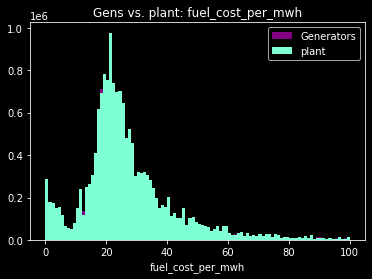

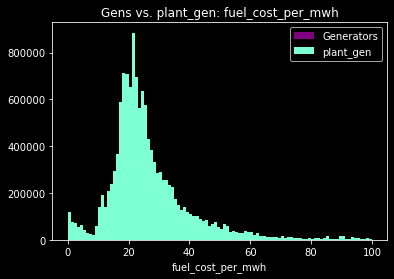

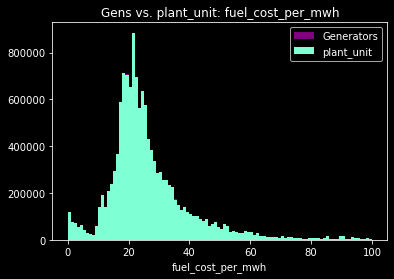

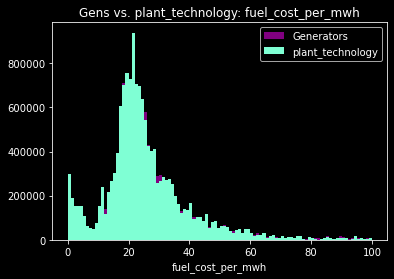

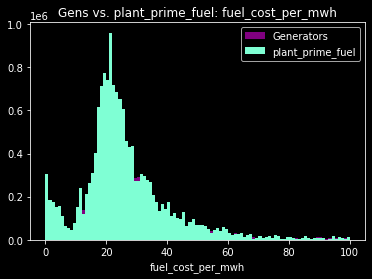

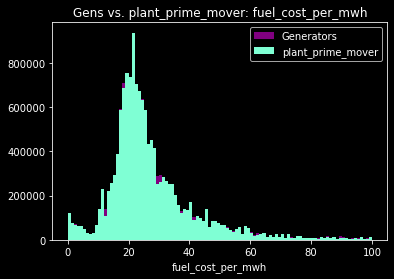

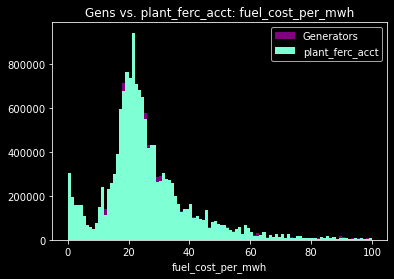

In [21]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

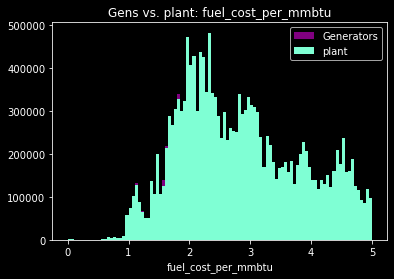

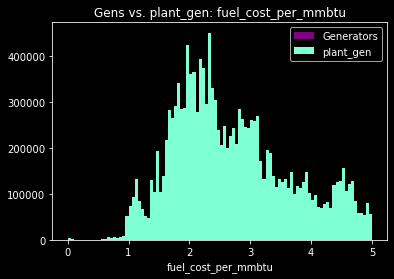

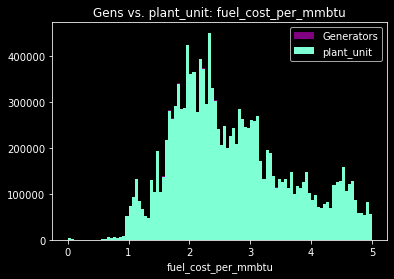

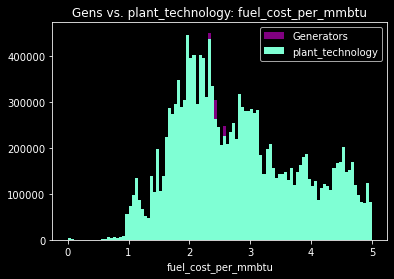

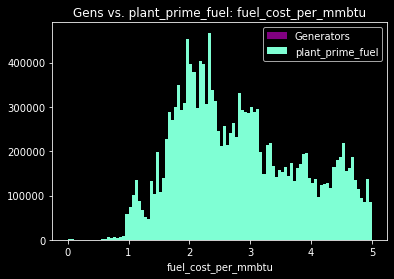

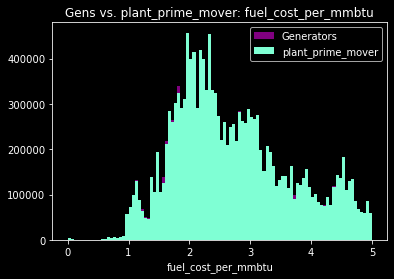

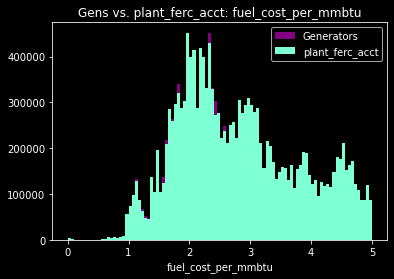

In [22]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [23]:
null_zeros = {0:np.NaN}
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    cpp_df = cpp_df.replace({
        'net_generation_mwh':null_zeros,
        'capacity_factor' : null_zeros,
        'fuel_cost_per_mmbtu': null_zeros,
        'fuel_cost_per_mwh': null_zeros,
        'capacity_mw': null_zeros,
                        })
    count_df = count_df.merge(
        pd.DataFrame(cpp_df#[cpp_df['report_date'].dt.year == 2018]
                     .count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover,plant_ferc_acct,total
plant_id_eia,282806,821523,69308,303468,311233,334409,286205,2408952
report_date,282806,821523,69308,303468,311233,334409,286205,2408952
plant_part,282806,821523,69308,303468,311233,334409,286205,2408952
generator_id,114742,821523,54458,132026,133430,155222,120521,1531922
unit_id_pudl,15116,98008,69308,20499,19773,28908,17720,269332
prime_mover_code,236840,818676,59543,278417,279032,334409,258872,2265789
energy_source_code_1,256350,821371,68584,301014,311233,322830,271461,2352843
technology_description,238044,778144,66857,303468,284947,305819,269622,2246901
ferc_acct_name,247860,775090,67028,300179,286916,314317,286205,2277595
utility_id_eia,282806,821523,69308,303468,311233,334409,286205,2408952
